In [2]:
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import TensorSpec
from tensorflow.data import Dataset
from tensorflow_federated.python.simulation.datasets import ClientData

In [3]:
train, test = tff.simulation.datasets.emnist.load_data()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [4]:
import json

f = open('most_frequent_labels.json')
d = json.load(f)
d2 = {}
for k, v in d.items(): 
    d2[train.client_ids[int(k)]] = v

In [5]:
BATCH_SIZE = 500

def preprocess(dataset):
    def helper(element):
        return (tf.reshape(element['pixels'], [-1, 784]), 
                tf.reshape(element['label'], [-1, 1]))
        # x=tf.reshape(element['pixels'], [-1, 784])
        # y=tf.reshape(element['label'], [-1, 1])
        # return collections.OrderedDict(x=x,y=y)

    return dataset.batch(BATCH_SIZE).map(helper)

In [6]:
def aux(client_id):
    dataset = train.create_tf_dataset_for_client(client_id)
    out = preprocess(dataset)
    out = next(iter(out))
    xs = out[0]
    ys = out[1]
    
    y_ind = tf.where(ys == d2[client_id]) 
    # d2[client_id] corresponds to the most frequent label in that client dataset
    gathered_ys = tf.gather_nd(ys, y_ind)
    
    x_ind = y_ind[:, 0]
    gathered_xs = tf.gather(xs, x_ind)
    
    return ((gathered_xs), (gathered_ys))

In [7]:
def dt_fn(client_id): 
    store = aux(client_id)
    return Dataset.from_tensor_slices({'pixels': store[0], 'label': store[1]})
    # return Dataset.from_tensor_slices((store[0], store[1]))

In [8]:
cd = ClientData.from_clients_and_tf_fn(train.client_ids, dt_fn) 
NUM_CLIENTS = len(train.client_ids)
assert len(cd.client_ids) == NUM_CLIENTS

2022-12-20 02:24:36.779946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x))
    # return [client_data.create_tf_dataset_for_client(x)
      for x in client_ids]

In [10]:
# we create a very simple model for classification 
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
    ])

def model_fn():
    keras_model = create_keras_model()
    inp_spec = (TensorSpec(shape=(None, 784,), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=inp_spec,           
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

**Federated algorithms have the following components:**

1. Server-to-client broadcast

2. Client model local update

3. Client-to-server upload

4. Server model update 

**We will create a boilerplate containing these four, then implement the components one by one.**

In [44]:
def next_fn(server_weights, federated_dataset):
  # Broadcast the server weights to the clients.
  server_weights_at_client = broadcast(server_weights)

  # Each client computes their updated weights.
  client_weights = client_update(federated_dataset, server_weights_at_client)

  # The server averages these updates.
  mean_client_weights = mean(client_weights)

  # The server updates its model.
  server_weights = server_update(mean_client_weights)

  return server_weights

**Of the above steps, the ones that can be completed in pure TensorFlow are steps 2 and 4, as they are simply the update steps of a neural network model. On the other hand, steps 1 and 3 require TensorFlow Federated.**

In [12]:
# decorator indicates that this is pure TensorFlow

@tf.function
def client_update(client_model, dataset, server_weights, client_optimizer):
  client_weights = client_model.trainable_variables
  # assign weights broadcasted from server to client local weights
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

  for batch in dataset:
    with tf.GradientTape() as tape:
      outputs = client_model.forward_pass(batch)

    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    client_optimizer.apply_gradients(grads_and_vars)

  return client_weights

In [53]:
### TODO: MUST UPDATE USING FEDERATEDAVERAGINGWITHSPREADOUT ALGORITHM
NUM_CLASSES = 10
MARGIN = 0.2
@tf.function
def server_update(server_model, mean_client_weights, server_optimizer):
  model_weights = server_model.trainable_variables
  auxiliary_matrix = tf.matmul(mean_client_weights, mean_client_weights)
  mask_ndiag = tf.logical_not(tf.cast(tf.eye(NUM_CLASSES), tf.bool))
  distances = tf.boolean_mask(auxiliary_matrix, mask_ndiag)
  spreadout_loss = tf.square(tf.nn.relu(MARGIN + distances))
  server_gradient = tf.gradients(spreadout_loss, mean_client_weights)
  lamb = server_optimizer.learning_rate.numpy()
  mean_client_weights -= lamb * server_gradient
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
  return model_weights

In [54]:
@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables

In [55]:
@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

In [56]:
tf_dataset_type = tff.SequenceType(model_fn().input_spec)
str(tf_dataset_type)

'<float32[?,784],int32[?,1]>*'

In [57]:
str(tf_dataset_type)

'<float32[?,784],int32[?,1]>*'

In [58]:
model_weights_type = server_init.type_signature.result
str(model_weights_type)

'<float32[784,10],float32[10]>'

In [59]:
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  model = model_fn()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  return client_update(model, tf_dataset, server_weights, client_optimizer)

In [ ]:
# add server optimizer 
@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  model = model_fn()
  server_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
  return server_update(model, mean_client_weights, server_optimizer)

In [ ]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [ ]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
  # step 1: broadcast server weights to the clients
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # step 2: client local update
  client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
  
  # step 3: server aggregates local updates
  mean_client_weights = tff.federated_mean(client_weights)

  # step 4: server model update
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights

In [ ]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [61]:
str(federated_algorithm.initialize.type_signature)

'( -> <float32[784,10],float32[10]>@SERVER)'

In [62]:
str(federated_algorithm.next.type_signature)

'(<server_weights=<float32[784,10],float32[10]>@SERVER,federated_dataset={<float32[?,784],int32[?,1]>*}@CLIENTS> -> <float32[784,10],float32[10]>@SERVER)'

In [63]:
final_test = test.create_tf_dataset_from_all_clients()
final_test = preprocess(final_test)

In [64]:
def evaluate(server_state):
  keras_model = create_keras_model()
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]  
  )
  keras_model.set_weights(server_state)
  return keras_model.evaluate(final_test)

In [65]:
losses = []
accuracies = []

In [66]:
server_state = federated_algorithm.initialize()
loss, acc = evaluate(server_state)
losses.append(loss)
accuracies.append(acc)

82/82 [==============================] - 4s 36ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0998


**We once again simulate the volatility as before by choosing N random clients to participate in the training round.**

In [67]:
def create_data_for_round(): 
    N = np.random.randint(10, 20)
    chosen_client_ids = np.random.randint(0, NUM_CLIENTS, N)
    chosen = [cd.client_ids[i] for i in chosen_client_ids]
    return make_federated_data(cd, chosen)

In [68]:
for round in range(100):
  federated_train_data = create_data_for_round()
  server_state = federated_algorithm.next(server_state, federated_train_data)
  loss, acc = evaluate(server_state)
  losses.append(loss)
  accuracies.append(acc)

82/82 [==============================] - 5s 47ms/step - loss: 2.4637 - sparse_categorical_accuracy: 0.1123


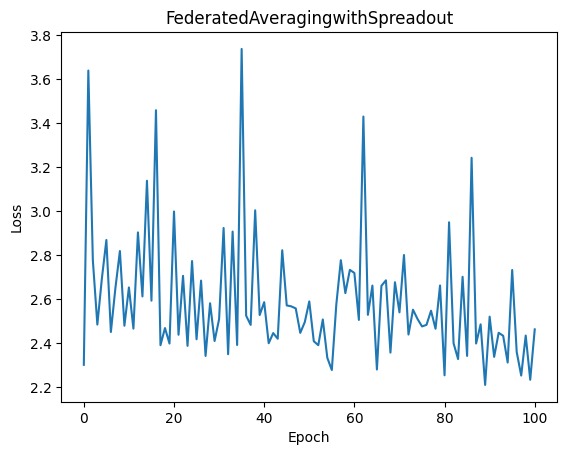

In [72]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("FederatedAveragingwithSpreadout")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

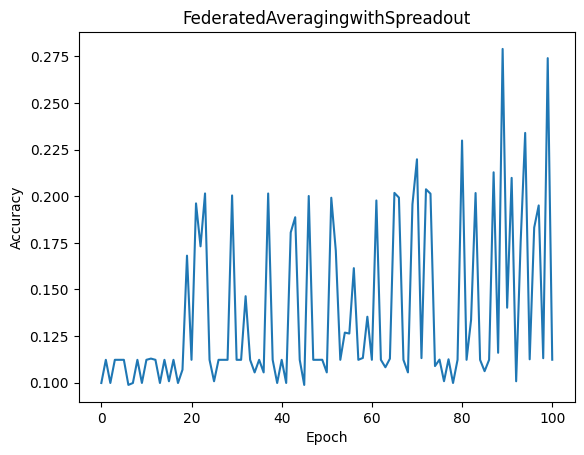

In [73]:
plt.plot(accuracies)
plt.title("FederatedAveragingwithSpreadout")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

**In conclusion, we observe that the fluctuation is still quite severe, but the overall accuracy shows a more evident upwards trend than it did with *FederatedAveraging*.**